In [82]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform


In [83]:
# Load dataset
df = pd.read_csv("Customer_Segmentation_Dataset.csv")
df = df.drop(columns=["CustomerID"])  # Remove non-numeric ID

In [84]:
# Separate numerical and categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove("SatisfactionRating")

In [85]:
# Define preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

In [86]:
# Separate features and target
X = df.drop("SatisfactionRating", axis=1)
y = df["SatisfactionRating"]

# Preprocess
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed,
                    columns=feature_names)
df_final = pd.concat([X_df, y.reset_index(drop=True)], axis=1)


In [87]:
# Save preprocessed dataset
df_final.to_csv("Preprocessed_Final_Dataset.csv", index=False)

In [88]:
# Load the preprocessed data
df = pd.read_csv("Preprocessed_Final_Dataset.csv")
X = df.drop(columns=["SatisfactionRating"])
y = df["SatisfactionRating"]

In [89]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [90]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}, cv=3)
rf_grid.fit(X_train, y_train)
rf_preds = rf_grid.predict(X_test)
print("Random Forest Best Params:", rf_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Random Forest Best Params: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.18
              precision    recall  f1-score   support

           1       0.14      0.06      0.08        69
           2       0.17      0.35      0.23        62
           3       0.22      0.20      0.21        49
           4       0.13      0.11      0.12        61
           5       0.23      0.19      0.21        59

    accuracy                           0.18       300
   macro avg       0.18      0.18      0.17       300
weighted avg       0.18      0.18      0.17       300



In [91]:
# ------------------- RANDOM FOREST RANDOMIZED SEARCH -------------------

rf_model = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None] + list(range(5, 21)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
rf_random_search.fit(X_train, y_train)

# Evaluate
rf_best_model = rf_random_search.best_estimator_
rf_accuracy = accuracy_score(y_test, rf_best_model.predict(X_test))
print("📌 Random Forest Best Params:", rf_random_search.best_params_)
print("📌 Random Forest Accuracy:", rf_accuracy)

📌 Random Forest Best Params: {'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 70}
📌 Random Forest Accuracy: 0.20333333333333334


In [92]:
# SVM
svc = SVC()
svc_grid = GridSearchCV(svc, {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}, cv=3)
svc_grid.fit(X_train, y_train)
svc_preds = svc_grid.predict(X_test)
print("\nSVM Best Params:", svc_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, svc_preds))
print(classification_report(y_test, svc_preds))


SVM Best Params: {'C': 0.1, 'kernel': 'rbf'}
Accuracy: 0.20666666666666667
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        69
           2       0.21      1.00      0.34        62
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        61
           5       0.00      0.00      0.00        59

    accuracy                           0.21       300
   macro avg       0.04      0.20      0.07       300
weighted avg       0.04      0.21      0.07       300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [93]:
# ------------------- SVC RANDOMIZED SEARCH -------------------

svc_model = SVC()
svc_param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svc_random_search = RandomizedSearchCV(
    estimator=svc_model,
    param_distributions=svc_param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
svc_random_search.fit(X_train, y_train)

# Evaluate
svc_best_model = svc_random_search.best_estimator_
svc_accuracy = accuracy_score(y_test, svc_best_model.predict(X_test))
print("📌 SVC Best Params:", svc_random_search.best_params_)
print("📌 SVC Accuracy:", svc_accuracy)

📌 SVC Best Params: {'C': np.float64(0.5645041271999772), 'gamma': 'scale', 'kernel': 'poly'}
📌 SVC Accuracy: 0.18333333333333332


In [94]:
# KMeans clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
sil_score = silhouette_score(X_scaled, kmeans_labels)
print("\nKMeans Silhouette Score:", sil_score)


KMeans Silhouette Score: 0.07075819237787327


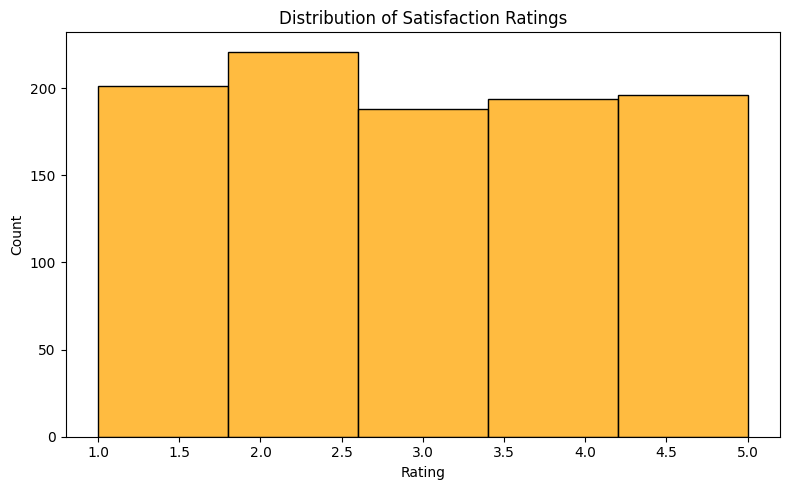

In [95]:
# Plot satisfaction distribution
df = pd.read_csv("Customer_Segmentation_Dataset.csv")
plt.figure(figsize=(8, 5))
sns.histplot(df["SatisfactionRating"], bins=5, kde=False, color='orange', edgecolor='black')
plt.title("Distribution of Satisfaction Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("satisfaction_distribution.png")
plt.show()

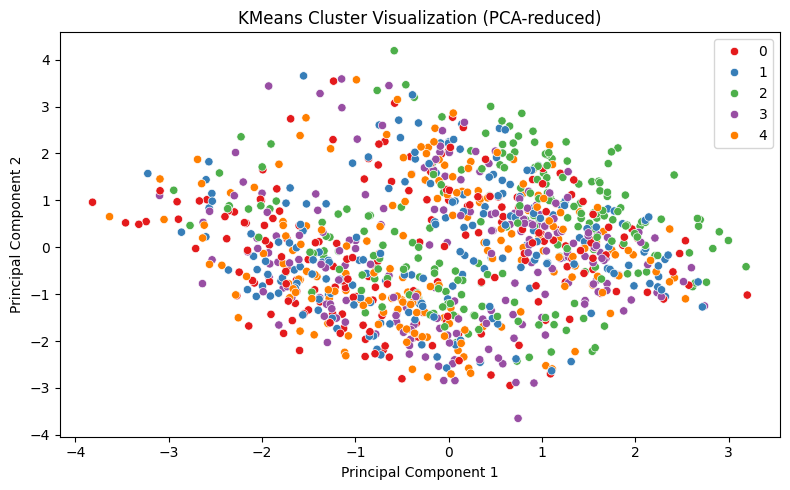

In [96]:
# KMeans Clustering Visualization
X = pd.read_csv("Preprocessed_Final_Dataset.csv").drop("SatisfactionRating", axis=1)
X_scaled = StandardScaler().fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_scaled)
labels = kmeans.labels_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', legend='full')
plt.title("KMeans Cluster Visualization (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.savefig("kmeans_clusters.png")
plt.show()

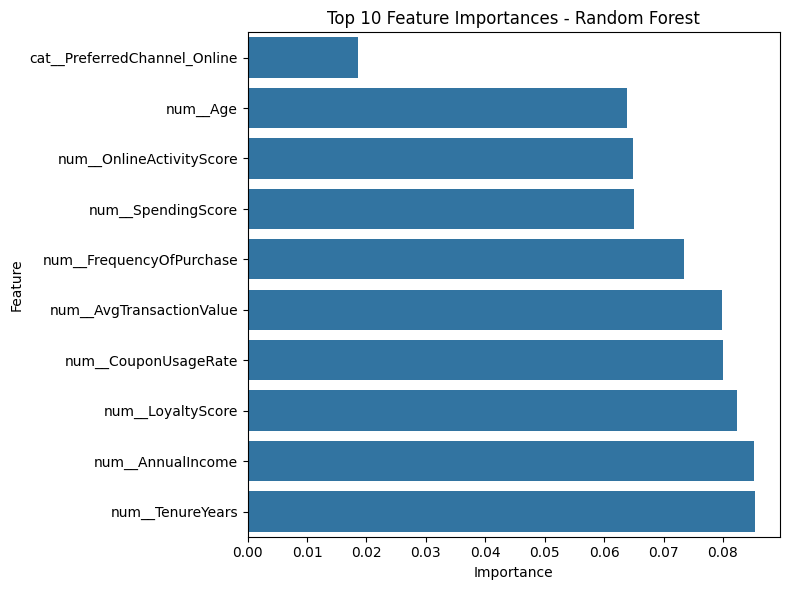

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assign best estimator from RandomizedSearchCV
rf_model = rf_random_search.best_estimator_

# Compute and plot top 10 feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features

plt.figure(figsize=(8, 6))
sns.barplot(x=importances[indices], y=np.array(X.columns)[indices])
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


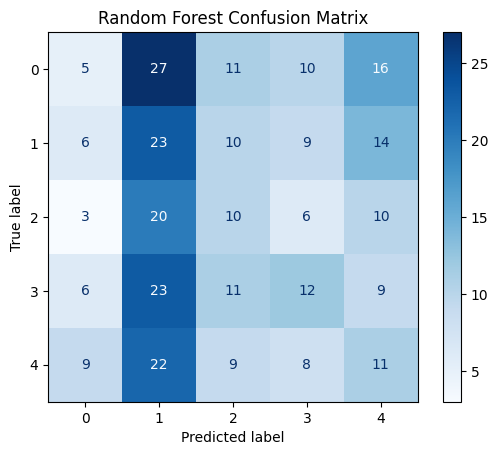

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from best random forest model
rf_model = rf_random_search.best_estimator_
rf_preds = rf_model.predict(X_test)

# Confusion matrix
cm_rf = confusion_matrix(y_test, rf_preds)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()


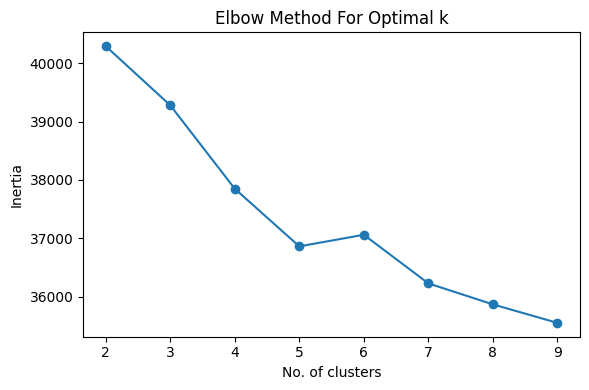

In [99]:
# Elbow method to choose optimal number of clusters
distortions = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    distortions.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, distortions, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("No. of clusters")
plt.ylabel("Inertia")
plt.tight_layout()
plt.savefig("kmeans_elbow.png")
plt.show()


In [100]:
import joblib

# Save the best models using best_estimator_
joblib.dump(rf_random_search.best_estimator_, "rf_model.pkl")
joblib.dump(svc_random_search.best_estimator_, "svc_model.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")

print("✅ Models saved as 'rf_model.pkl', 'svc_model.pkl', and 'kmeans_model.pkl'")


✅ Models saved as 'rf_model.pkl', 'svc_model.pkl', and 'kmeans_model.pkl'
